In [29]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_csv('path to dataset')
test_df = pd.read_csv('path to dataset')
val_df = pd.read_csv('path to dataset')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 12967
Validation samples: 1621
Test samples: 1621


In [3]:
train_images_df = train_df['image_path'].copy()
train_df.drop('image_path', axis=1, inplace=True)

test_images_df = test_df['image_path'].copy()
test_df.drop('image_path', axis=1, inplace=True)

val_images_df = val_df['image_path'].copy()
val_df.drop('image_path', axis=1, inplace=True)

In [4]:
def load_images(image_paths, target_size=(64, 64)):
    images = []
    for idx in range(len(image_paths)):
        img = load_img(image_paths.iloc[idx], target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        images.append(img_array)
    return np.array(images)

In [5]:
def augment_images(images):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    augmented_images = []
    for img in images:
        img_reshaped = img.reshape((1,) + img.shape)
        aug_iter = datagen.flow(img_reshaped, batch_size=1)
        augmented_images.append(next(aug_iter)[0])
    
    return np.array(augmented_images)

In [6]:
print("Loading images...")
train_images = load_images(train_images_df)
test_images = load_images(test_images_df)
val_images = load_images(val_images_df)

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Val images shape: {val_images.shape}")

Loading images...
Train images shape: (12967, 64, 64, 3)
Test images shape: (1621, 64, 64, 3)
Val images shape: (1621, 64, 64, 3)


In [7]:
print("Augmenting training images...")
train_images_aug = augment_images(train_images)
print(f"Augmented training images shape: {train_images_aug.shape}")

Augmenting training images...
Augmented training images shape: (12967, 64, 64, 3)


In [8]:
train_images_processed = preprocess_input(train_images_aug * 255.0)
test_images_processed = preprocess_input(test_images * 255.0)
val_images_processed = preprocess_input(val_images * 255.0)

In [9]:
X_train = train_df.drop('price', axis=1)
y_train = train_df['price'].values.astype(np.float32)

X_test = test_df.drop('price', axis=1)
y_test = test_df['price'].values.astype(np.float32)

X_val = val_df.drop('price', axis=1)
y_val = val_df['price'].values.astype(np.float32)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)
X_val_scaled = scaler.transform(X_val).astype(np.float32)

print(f"Numerical features shape: {X_train_scaled.shape}")
print(f"Price range - Min: {y_train.min():.2f}, Max: {y_train.max():.2f}, Mean: {y_train.mean():.2f}")

Numerical features shape: (12967, 18)
Price range - Min: 4.90, Max: 6.89, Mean: 5.66


In [10]:
image_input = layers.Input(shape=(64, 64, 3), name="image_input")

base_cnn = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=image_input
)

for layer in base_cnn.layers:
    layer.trainable = False

x1 = base_cnn.output
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(64, activation="relu")(x1)
x1 = layers.Dropout(0.5)(x1)

num_input = layers.Input(shape=(X_train_scaled.shape[1],), name="num_input")

x2 = layers.Dense(128, activation="relu")(num_input)
x2 = layers.Dropout(0.3)(x2)
x2 = layers.Dense(64, activation="relu")(x2)
x2 = layers.Dropout(0.3)(x2)

merged = layers.Concatenate()([x1, x2])

z = layers.Dense(64, activation="relu")(merged)
z = layers.Dropout(0.3)(z)
z = layers.Dense(32, activation="relu")(z)

output = layers.Dense(1, activation="linear", name="output")(z)

model = Model(
    inputs=[num_input, image_input],
    outputs=output,
    name='multimodal_price_predictor'
)

print("Model created successfully")

Model created successfully


In [11]:
model.summary()

Model: "multimodal_price_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,739,905 (90.56 MB)

 Trainable params: 152,193 (594.50 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 6. Compile and Train Model

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [13]:
history = model.fit(
    [X_train_scaled, train_images_processed], y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_scaled, val_images_processed], y_val),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 2.6010 - mae: 1.1665 - val_loss: 3.5828 - val_mae: 1.8315 - learning_rate: 0.0010
Epoch 2/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 0.7426 - mae: 0.6762 - val_loss: 5.1415 - val_mae: 2.2521 - learning_rate: 0.0010
Epoch 3/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - loss: 0.4699 - mae: 0.5356 - val_loss: 4.7353 - val_mae: 2.1654 - learning_rate: 0.0010
Epoch 4/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - loss: 0.3387 - mae: 0.4516 - val_loss: 3.4292 - val_mae: 1.8398 - learning_rate: 0.0010
Epoch 5/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 107s 265ms/step - loss: 0.2372 - mae: 0.3805 - val_loss: 2.8056 - val_mae: 1.6653 - learning_rate: 0.0010
Epoch 6/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 0.1533 - mae: 0.3058 - val_loss: 1.6040 - val_mae: 1.2570 - learning_rate: 0.0010
Epoch 7/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - loss: 0.0859 - mae: 0.2291 - val_loss: 0.6640 - val_mae: 0.8011 - learn

## 7. Evaluate Model

In [14]:
y_pred = model.predict([X_test_scaled, test_images_processed])

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print("="*50)

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step

TEST SET PERFORMANCE
Root Mean Squared Error: 0.0882
Mean Absolute Error: 0.0650
R2 Score: 0.8513


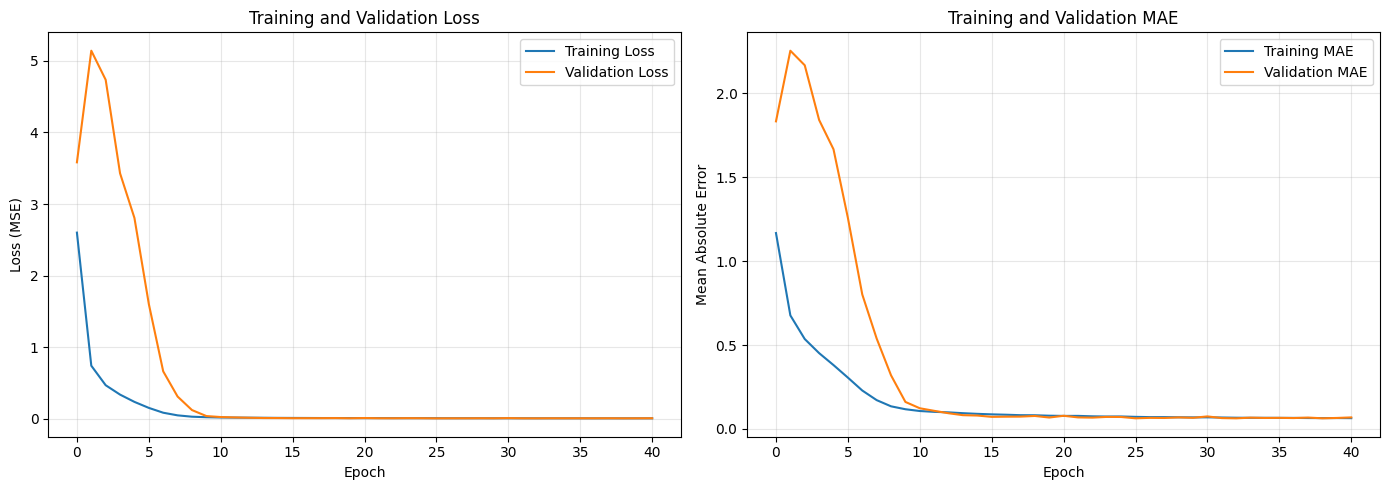

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

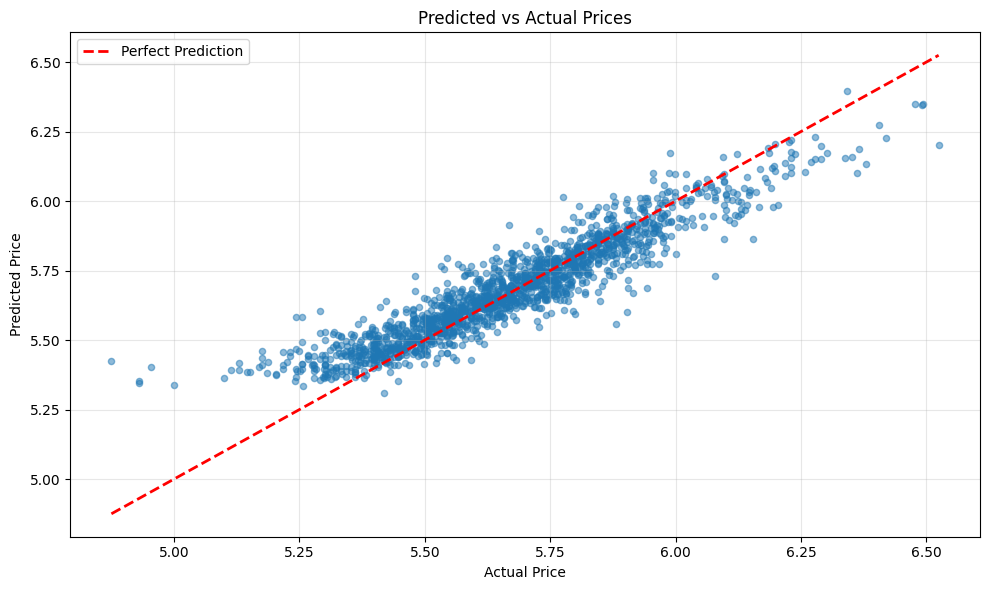

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

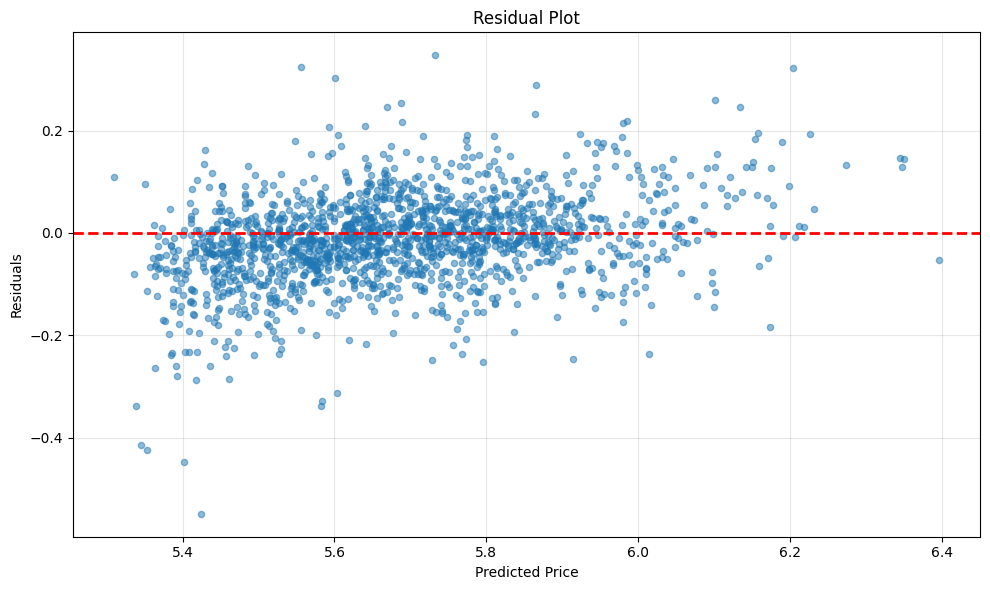

In [17]:
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df_test = pd.read_csv('path to dataset')
null_idx = df_test.index[df_test['image_path'].isna()]
df_test.dropna(inplace=True)

In [79]:
TestImages = load_images(df_test['image_path'])

In [80]:
TestX_num = df_test.drop('image_path',axis=1).copy()
TestX_num_array = TestX_num.values.astype(np.float32)

In [81]:
TestPredicted = model.predict([TestX_num_array,TestImages])
TestPredicted = np.power(10,TestPredicted)
TestPredicted

169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step


array([[ 642571.44],
       [ 886172.7 ],
       [1244351.4 ],
       ...,
       [ 589711.25],
       [1432333.  ],
       [ 634354.4 ]], dtype=float32)

In [ ]:
test_with_ID = pd.read_csv('path to original test dataset') #this extra step was added as we need ID in the final predicted file and it was dropped during preprocessing 
test_with_ID.drop(null_idx,inplace=True)

final_df = pd.DataFrame()

final_df['id'] = test_with_ID['id'].copy()
final_df['predicted_prices'] = TestPredicted

final_df.to_csv('path to save predicted prices',index=False)